# Process Cap Quotes

This notebook 
* converts Bloomberg cap quotes into Black flat vols.
* interpolates the vol curve
* interpolates the SOFR swap curve from BB quotes.
* calculates swap, discount, and forward curves

User picks a date, and among the historic dates loaded, it builds the curves for this particular date.

Pair this notebook with `build_data/Build Cap Quotes - Bloomberg`.

In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

import sys
sys.path.insert(0, '../cmds')
from ratecurves import *
from ficcvol import *
from treasury_cmds import compound_rate
from bondmath import bootstrap_discounts_clean

from datetime import datetime
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

***

In [3]:
FILEDATE = '2025-01-31'
FILEIN = f'../build_data/cap_quotes_{FILEDATE}'
BB_COMPOUND = 1 #compounding of quoted SOFR swaps
freqcap = 4
# can adjust frequency for binomial tree later, but keep freqcap quarterly to properly get caps
freqcurve = 4
# later, interpolate the grid
freq_curve_interp = 4
ROUND = 4

### Select Date for Analysis

In [4]:
DATE = '2025-01-31'

### Export Curves to Excel

In [5]:
SAVEDATA = True
FILEOUT = f'../data/cap_curves_{DATE}.xlsx'

# SOFR Quotes

In [6]:
SHEET = 'sofr'
sofrdata_raw = pd.read_excel(f'{FILEIN}.xlsx', sheet_name=SHEET).set_index('date')
sofrdata_raw.columns = sofrdata_raw.loc['maturity'] 
sofrdata_raw.drop(index=['maturity'],inplace=True)
sofrdata_raw.index = pd.to_datetime(sofrdata_raw.index)

sofrdata_raw.columns.name ='maturity'

Bloomberg reports rates as percentages; convert to numbers.

In [7]:
sofrdata_raw /= 100

Bloomberg allows downloading of ticker codes corresponding to 10.X years, but they are really just the 10-year code.

Called ticker list built to check all partial years, so it gets these redundant 10-year columns.

In [8]:
sofrdata_raw = sofrdata_raw.T.drop_duplicates().T

## Get Curves

Need discount and forward curves.

Need to interpolate swap rates for quarterly frequency beyond $T=3$ (which is where Bloomberg moves from monthly to semiannual tenors.)

Many reasonable methods, try `cubicspline`.

### Compounding

Bloomberg is quoting the swap rates per the swap frequency.

SOFR swaps are listed as annual frequency.

For convenience of our `freqcap` grid, convert this compounding.

In [9]:
sofrdata = sofrdata_raw.copy()
sofrdata = compound_rate(sofrdata,BB_COMPOUND,freqcurve)
sofrdata.tail().style.format('{:.2%}').format_index('{:%Y-%m-%d}',axis=0).format_index('{:.2f}',axis=1)

maturity,0.24,0.50,0.75,1.00,1.24,1.49,1.75,2.00,2.24,2.49,2.75,3.00,3.50,4.00,4.50,5.00,6.00,7.00,8.00,9.00,10.00
date,,,,,,,,,,,,,,,,,,,,,
2025-01-27,4.23%,4.17%,4.12%,4.08%,4.03%,4.00%,3.98%,3.98%,3.96%,3.96%,3.96%,3.96%,3.96%,3.96%,3.96%,3.97%,3.98%,3.98%,3.99%,4.00%,4.01%
2025-01-28,4.22%,4.17%,4.12%,4.08%,4.03%,4.00%,3.98%,3.98%,3.96%,3.96%,3.96%,3.96%,3.95%,3.96%,3.96%,3.96%,3.97%,3.98%,3.99%,4.00%,4.01%
2025-01-29,4.24%,4.19%,4.14%,4.10%,4.05%,4.02%,4.00%,4.00%,3.98%,3.97%,3.97%,3.97%,3.97%,3.97%,3.97%,3.97%,3.98%,3.98%,3.99%,4.00%,4.01%
2025-01-30,4.24%,4.19%,4.14%,4.10%,4.05%,4.02%,4.00%,4.00%,3.98%,3.97%,3.97%,3.97%,3.96%,3.96%,3.96%,3.96%,3.97%,3.97%,3.98%,3.99%,4.00%
2025-01-31,4.24%,4.19%,4.14%,4.10%,4.05%,4.01%,4.00%,3.99%,3.97%,3.96%,3.96%,3.97%,3.96%,3.97%,3.97%,3.97%,3.98%,3.99%,4.00%,4.01%,4.02%


In [10]:
T = np.ceil(sofrdata.columns[-1])

In [11]:
dt = np.round(1 / freqcurve,ROUND)
new_index = np.arange(dt, T+dt, dt)

sofrcurves_cap = pd.DataFrame(index=new_index, columns=['swap rates'])
interp_func = interp1d(sofrdata.columns, sofrdata.loc[DATE].T, kind='linear',fill_value='extrapolate', bounds_error=False)
sofrcurves_cap['swap rates'] = interp_func(new_index)

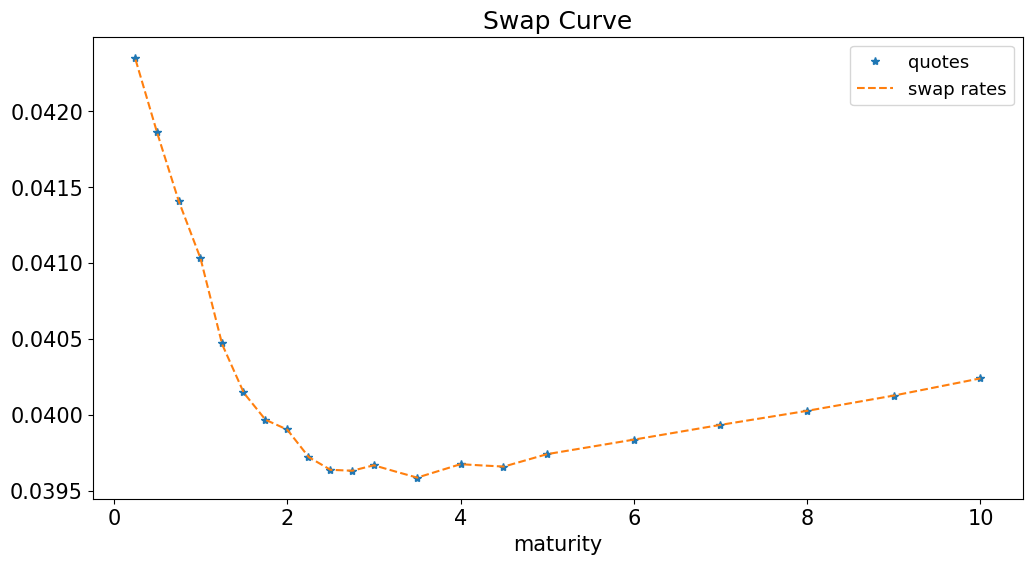

In [12]:
# sofrcurves_cap = interp_curves(sofrdata, dt = 1/freqcurve, date=DATE, interp_method='linear').rename(columns={'interp':'swap rates'})
sofrquotes = sofrdata.loc[DATE,:].rename('quotes')

### Plot the Curve
fig, ax = plt.subplots()
sofrquotes.plot.line(ax=ax, linestyle='None',marker='*')
sofrcurves_cap['swap rates'].plot.line(ax=ax, linestyle='--',marker='')
plt.legend();
plt.title('Swap Curve');

In [13]:
sofrcurves_cap['spot rates'] = bootstrap_discounts_clean(sofrcurves_cap[['swap rates']],compounding=freqcurve,key='swap rates')

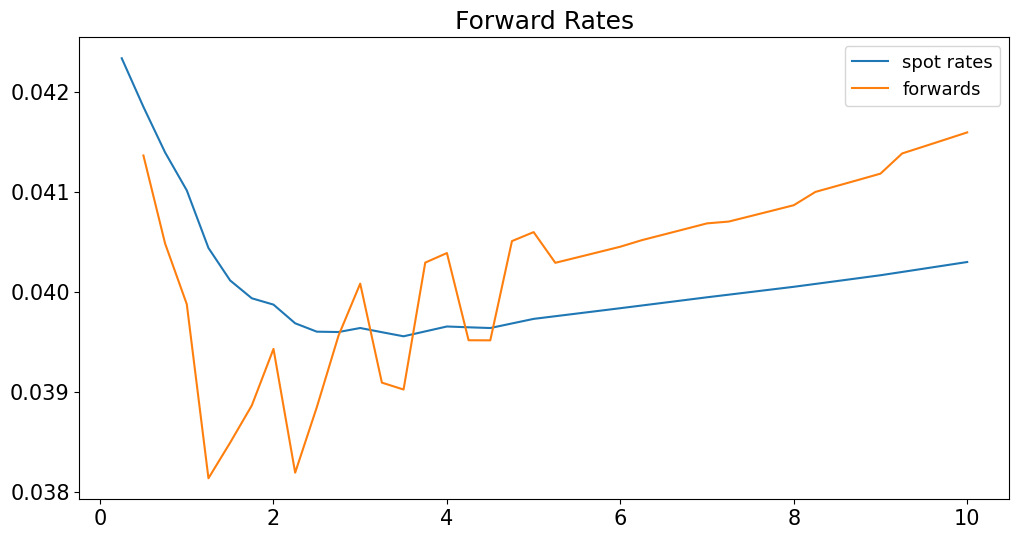

In [14]:
sofrcurves_cap['discounts'] = ratecurve_to_discountcurve(sofrcurves_cap['spot rates'],n_compound=freqcurve)
sofrcurves_cap['forwards'] = ratecurve_to_forwardcurve(sofrcurves_cap['spot rates'],n_compound=freqcurve)
sofrcurves_cap[['spot rates','forwards']].plot(title='Forward Rates');

In [15]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def nelson_siegel_yield(t, beta0, beta1, beta2, tau):
    """
    Nelson-Siegel instantaneous yield (spot rate) function.
    Handles t == 0 safely.
    """
    t = np.asarray(t)
    # For t == 0, set the loading to its limit value
    L = np.where(t == 0, 1.0, (1 - np.exp(-t/tau)) / (t/tau))
    term2 = np.where(t == 0, 0.0, (1 - np.exp(-t/tau)) / (t/tau) - np.exp(-t/tau))
    return beta0 + beta1 * L + beta2 * term2

def discount_factor_ns(t, beta0, beta1, beta2, tau):
    """
    Nelson-Siegel discount factor function:
      DF(t) = exp(-t * y(t))
    where y(t) is given by the Nelson-Siegel yield function.
    """
    y = nelson_siegel_yield(t, beta0, beta1, beta2, tau)
    return np.exp(-t * y)

def fit_nelson_siegel(discount_factors, num_points=100, new_index=None):
    """
    Fit the Nelson-Siegel model to discount factor data and return
    a fitted curve of spot rates (yields).

    Parameters:
        discount_factors : pandas Series or one-column DataFrame
            The discount factors, indexed by time-to-maturity.
        num_points : int, optional
            Number of points for the output fitted curve if new_index is not provided.
        new_index : array-like, optional
            An optional new index (time grid) on which to evaluate the fitted Nelson-Siegel curve.
    
    Returns:
        fitted_curve : pandas Series
            Fitted spot rates (yields) evaluated on the provided new_index or a generated index.
        params : dict
            Fitted parameters {beta0, beta1, beta2, tau}.
    """
    # If a DataFrame is provided, assume it has a single column.
    if isinstance(discount_factors, pd.DataFrame):
        if discount_factors.shape[1] != 1:
            raise ValueError("Input DataFrame must have exactly one column.")
        discount_factors = discount_factors.iloc[:, 0]
    elif not isinstance(discount_factors, pd.Series):
        raise ValueError("Input must be a pandas Series or a one-dimensional DataFrame.")

    # Extract time-to-maturity (t) and discount factor values.
    t = discount_factors.index.values.astype(float)
    df_values = discount_factors.values.astype(float)

    # Initial guess for [beta0, beta1, beta2, tau]
    p0 = [0.03, -0.02, 0.02, 1.0]

    # Fit the discount factor curve using nonlinear least squares.
    popt, _ = curve_fit(discount_factor_ns, t, df_values, p0=p0, maxfev=10000)
    beta0, beta1, beta2, tau = popt

    # Determine new index for the fitted curve
    if new_index is None:
        # Generate evenly spaced points from 0 to max maturity
        t_new = np.linspace(0, t.max(), num_points)
    else:
        t_new = np.asarray(new_index).astype(float)

    # Compute the fitted spot rates using the Nelson-Siegel yield function.
    fitted_spot_rates = nelson_siegel_yield(t_new, beta0, beta1, beta2, tau)

    # Return a Series of fitted spot rates (indexed by t_new) and the fitted parameters.
    fitted_curve = pd.Series(fitted_spot_rates, index=t_new, name="spot rates")
    params = {"beta0": beta0, "beta1": beta1, "beta2": beta2, "tau": tau}

    return fitted_curve, params

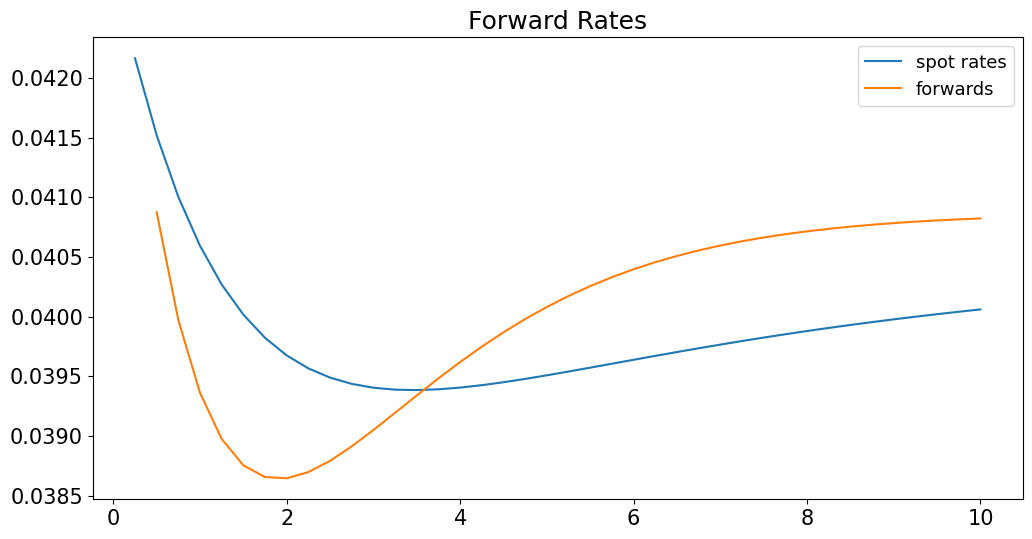

In [16]:
freqcurve = freq_curve_interp

dt = np.round(1/freqcurve,ROUND)
custom_index = np.arange(dt, T+dt,dt)

# Code for non-uniform grid
# dense_grid = np.linspace(0, 0.5, 127)         # e.g. 0.01-year steps up to 0.5
# coarse_grid = np.linspace(0.5, 5, 19)          # e.g. roughly 0.25-year steps thereafter
# # Avoid duplicating the 0.5 point.
# custom_index = np.concatenate([dense_grid, coarse_grid[1:]])

fitted_curve, params = fit_nelson_siegel(sofrcurves_cap['discounts'], new_index=custom_index)

sofrcurves = fitted_curve.to_frame()
sofrcurves['discounts'] = ratecurve_to_discountcurve(sofrcurves['spot rates'],n_compound=freqcurve)
sofrcurves['forwards'] = ratecurve_to_forwardcurve(sofrcurves['spot rates'],n_compound=freqcurve)
sofrcurves['swap rates'] = compound_rate(-np.log(sofrcurves['discounts'])/sofrcurves.index,None,freqcurve)
sofrcurves[['spot rates','forwards']].plot(title='Forward Rates');

In [17]:
sofrcurves

,spot rates,discounts,forwards,swap rates
0.25,0.042164,0.989569,NaN,0.042164
0.50,0.041519,0.979559,0.040874,0.041519
0.75,0.041003,0.969868,0.039971,0.041003
1.00,0.040593,0.960417,0.039362,0.040593
1.25,0.040269,0.951149,0.038976,0.040269
1.50,0.040017,0.942022,0.038755,0.040017
1.75,0.039822,0.933005,0.038657,0.039822
2.00,0.039676,0.924077,0.038647,0.039676
2.25,0.039567,0.915222,0.038699,0.039567
2.50,0.039490,0.906431,0.038793,0.039490


# Cap Quotes

In [18]:
SHEET = 'cap'
capdata = pd.read_excel(f'{FILEIN}.xlsx', sheet_name=SHEET).set_index('date')
capdata.columns = capdata.loc['maturity'] 
capdata.drop(index=['maturity'],inplace=True)
capdata.index = pd.to_datetime(capdata.index)

Bloomberg reported years-to-maturity are precise.
Round these to nearest $dt$ for better column headers
For more precise work, would need to make use of the precise maturities, but for this purpose will make no difference.

In [19]:
capdata.columns = (freqcap * capdata.columns.values).round(0)/freqcap
capdata.columns.name ='maturity'

Bloomberg allows downloading of ticker codes corresponding to 10.X years, but they are really just the 10-year code.

Called ticker list built to check all partial years, so it gets these redundant 10-year columns.

In [20]:
capdata = capdata.T.drop_duplicates().T

## Adjusting Normal Vol to Lognormal (Black) Vol

Cap quotes in Bloomberg are downloaded in
* normal vol
* terminal allows view of lognormal (Black) vol, but API seemingly restricts to normal.

The normal vols are reported in basis points.
* divide out by $100^2$

Converting between normal and lognormal vol is given by a simple formula for ATM options, (according to SABR, etc.)

$$\sigma_B = \frac{\sigma_N}{f}$$

where $f$ is the forward rate.

In [21]:
capquotes = capdata.loc[DATE,:].to_frame()
capquotes.columns = ['normal']
capquotes[DATE] = capquotes['normal'] / sofrcurves_cap['forwards'] / 100**2

# Interpolate or Extrapolate

Interpolate/extrapolate just to get to quarterly frequency needed for forward vol extraction.

After extracting forward vol, can interpolate/extrapolate further for matching timegrid of binomial trees.

#### Interpolation
Need to interpolate cap rates for quarterly frequency as Bloomberg reports only at annual tenors.

Try `cubicspline`.

#### Extrapolation
Also need to extrapolate the short end of the curve, $t<1$.
* This can lead to negative values w/ cubic spline and others.
* Here, ad hoc set front to `FRONT_RATIO` the first quote and linearly extrapolate

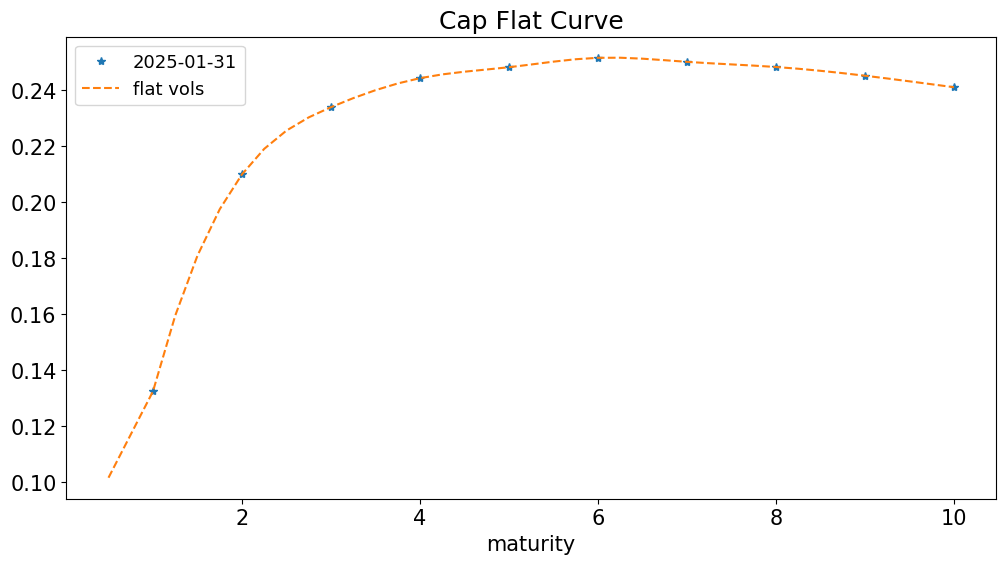

In [22]:
LIN_EXTRAP = True
FRONT_RATIO = .65
dt = np.round(1/freqcap,ROUND)
capcurves = interp_curves(capquotes[[DATE]].T,dt=dt, date=DATE,interp_method='cubicspline').rename(columns={'interp':'flat vols'})

if LIN_EXTRAP:
    fix_short = capcurves.loc[:1,'flat vols']
    fix_short.iloc[:-1] = np.nan
    fix_short.iloc[0] = capcurves.loc[1,'flat vols'] * FRONT_RATIO
    capcurves.loc[:1,'flat vols'] = fix_short.interpolate(limit_direction='both', fill_value = 'extrapolate')

# drop extrapolated value at first period as there is no caplet for the first period.
capcurves['flat vols'].iloc[0] = np.nan

### Plot the Curve
fig, ax = plt.subplots()
capquotes[[DATE]].rename(columns={'black':'quotes'}).plot.line(ax=ax, linestyle='None',marker='*')
capcurves['flat vols'].plot.line(ax=ax, linestyle='--',marker='')
plt.legend();
plt.title('Cap Flat Curve');

In [23]:
capcurves = flat_to_forward_vol_rev(capcurves['flat vols'],sofrcurves_cap['swap rates'],sofrcurves_cap['forwards'],sofrcurves_cap['discounts'],freq=freqcap)

In [24]:
# Calculate time step parameters as before
dt = np.round(1 / freqcurve,ROUND)
new_index = np.arange(dt, T, dt)

new_index = custom_index

capcurves_alt = pd.DataFrame(index=new_index, columns=capcurves.columns)

for col in capcurves.columns:
    # Use only valid, strictly positive values for log interpolation
    valid_mask = capcurves[col].notna() & (capcurves[col] > 0)
    valid_indices = capcurves.index[valid_mask]
    valid_values = capcurves[col][valid_mask]
    
    # Take logarithm of the valid values for interpolation in log-space
    log_valid_values = np.log(valid_values)
    
    # Create interpolation function in log-space
    interp_func = interp1d(valid_indices, log_valid_values, kind='linear', 
                           fill_value='extrapolate', bounds_error=False)
    
    # Interpolate in log-space and then exponentiate to get back to the original scale
    interpolated_log_values = interp_func(new_index)
    capcurves_alt[col] = np.exp(interpolated_log_values)

capcurves_alt.iloc[0,:] = np.nan

### Save Data

In [25]:
outdata = pd.concat([sofrcurves, capcurves_alt.drop(columns=['cap prices'])],axis=1)
outdata.index.name = 'tenor'

if SAVEDATA:    
    with pd.ExcelWriter(FILEOUT) as writer:  
        outdata.to_excel(writer, sheet_name= f'rate curves {DATE}', index=True)